## Setup
Necessary library imports and network design

In [1]:
# Import Tensorflow backend
import tensorflow as tf
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

/home/runceko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 563063830523948373, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3867541504
 locality {
   bus_id: 1
 }
 incarnation: 90048129494609884
 physical_device_desc: "device: 0, name: GeForce GTX 960, pci bus id: 0000:03:00.0, compute capability: 5.2"]

In [4]:
# Part 1 - Building the CNN 
# Importing the Keras libraries and packages
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.callbacks import CSVLogger

# Misc
import time
import datetime
import os

# Visualise
import matplotlib.pyplot as plt
import numpy
import json

# Display progress
from ipywidgets import FloatProgress
from IPython.display import display

In [5]:
run_name = "test_new_location_b256"

general_hyperparams = {
    "epochs": 5,
    "batch_size": 256,
    "padding": "same",
    "activation": "relu",
    "optimizer": "adam",
    "error": "binary_crossentropy",
    "dropout": 0.5,
    "data_aug": {
        "shear_range": 0.2,
        "zoom_range": 0.2,
        "horizontal_flip": True
    }
}

# Initialising the CNN
classifier = Sequential()
 
# Convolution
classifier.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    padding=general_hyperparams["padding"],
    activation=general_hyperparams["activation"],
    input_shape=(64, 64, 3)
))
 
# Max Pooling
classifier.add(MaxPooling2D(strides=(2,2)))
 
# Flatening
classifier.add(Flatten())
 
# Full connection
classifier.add(Dense(units=128, activation="relu"))

# Dropout
classifier.add(Dropout(general_hyperparams["dropout"]))
 
# Output 
classifier.add(Dense(units=1, activation='sigmoid'))
 
# Compiling the CNN
classifier.compile(
    optimizer=general_hyperparams["optimizer"],
    loss=general_hyperparams["error"],
    metrics=['accuracy'])

## Data Load / Augmentation
Data is loaded into generators, acting as sources during training. Here data is also cropped to required size and augmented by shearing, zooming and flipping.

In [6]:
# random transformations (rotations, flipping, shifting)
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=general_hyperparams["data_aug"]["shear_range"],
        zoom_range=general_hyperparams["data_aug"]["zoom_range"],
        horizontal_flip=general_hyperparams["data_aug"]["horizontal_flip"])
    
valid_datagen = ImageDataGenerator(rescale=1./255)
 
training_set = train_datagen.flow_from_directory('../data/train',
                                                classes=["dogs", "cats"],
                                                target_size=(64, 64),
                                                batch_size=general_hyperparams["batch_size"],
                                                class_mode='binary')
 
valid_set = valid_datagen.flow_from_directory('../data/valid',
                                            classes=["dogs", "cats"],
                                            target_size=(64, 64),
                                            batch_size=general_hyperparams["batch_size"],
                                            class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## Training
Here the model is trained. Beforehand, it is timestamped and its parameters are saved for quicker inspection in the future.

An empty file is saved, with its name mimicking the save folder for the network. While currently not implemented, this will be a way for the network to automatically continue training if stopped abruptly.

Possibly Tensorboard would have contained more info, but I find simple json files quicker to inspect.

In [7]:
st = datetime.datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d %H:%M:%S')
save_dir = "../results/" + run_name + " @ " + st
try:
    os.mkdir(save_dir)
except:
    pass

plot_model(classifier, to_file=save_dir + '/model.png', show_shapes=True)
with open(save_dir + "/general_hparams.txt", 'w') as general_hparams_file:
     general_hparams_file.write(json.dumps(general_hyperparams, indent=4, sort_keys=True)) 
    
csv_logger = CSVLogger(save_dir + "/log.csv", append=True, separator=';')
    
# Train
history = classifier.fit_generator(training_set,
                        steps_per_epoch=20000/general_hyperparams["batch_size"],# number of samples divided by batch size
                        epochs=general_hyperparams["epochs"],
                        validation_data=valid_set,
                        validation_steps=5000/general_hyperparams["batch_size"],
                        use_multiprocessing=True,
                        workers=16,
                        max_queue_size=25,
                        callbacks=[csv_logger])

Epoch 1/5
79/78 [==============================] - 27s 344ms/step - loss: 0.7996 - acc: 0.5486 - val_loss: 0.6529 - val_acc: 0.6228
Epoch 2/5
79/78 [==============================] - 17s 211ms/step - loss: 0.6397 - acc: 0.6415 - val_loss: 0.5974 - val_acc: 0.6878
Epoch 3/5
79/78 [==============================] - 17s 211ms/step - loss: 0.5976 - acc: 0.6842 - val_loss: 0.5608 - val_acc: 0.7130
Epoch 4/5
79/78 [==============================] - 16s 208ms/step - loss: 0.5649 - acc: 0.7127 - val_loss: 0.5277 - val_acc: 0.7360
Epoch 5/5
79/78 [==============================] - 17s 211ms/step - loss: 0.5535 - acc: 0.7212 - val_loss: 0.5188 - val_acc: 0.7404


## Training evaluation
The training loss and accuracies are plotted.

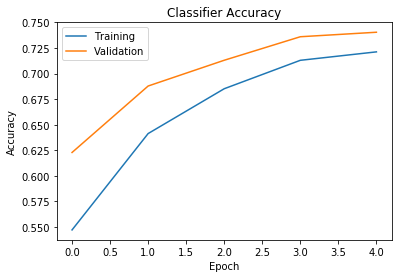

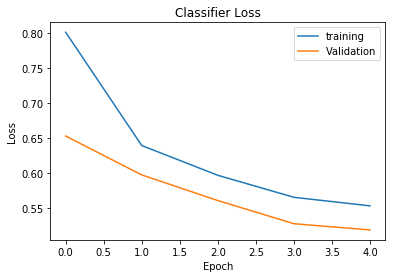

In [9]:
# Save classifier
classifier.save(save_dir + "/checkpoint.h5")

# summarize hisotry for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Classifier Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.savefig(save_dir + '/accuracy.png')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Classifier Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training', 'Validation'])
plt.savefig(save_dir + '/loss.png')
plt.show()

## Generate Test Prediction

The results are generated for a given labeled test set. CSV file for unlabeled Kaggle test set is provided too.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import numpy as np

import matplotlib.pyplot as plt

import csv

# Display progress
from ipywidgets import FloatProgress
from IPython.display import display

#### Test with my cats
All 6 pictures depict cats

In [ ]:
import numpy as np
classifier = load_model(save_dir + "/checkpoint.h5")

test_folder = "../data/test_mine/" 

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_folder,
                                             classes=["cats", "dogs"],
                                             target_size=(64,64),
                                             batch_size=general_hyperparams["batch_size"],
                                             class_mode="binary",  # only data, no labels
                                             shuffle=False)

predictions = classifier.predict_generator(test_set)
predictions_rounded = predictions.round()

preds = []
for i in range(len(predictions)):
    for k,v in test_set.class_indices.items():
        if v == predictions_rounded[i]:
            preds.append((predictions[i], k))
            break
            
# Display predictions  
test_set.reset()
x, y = test_set.next()

plt.figure(1)
for i in range(6):
    image = x[i]
    ax = plt.subplot(2, 3, i+1)
    plt.imshow(image)
    ax.set_title("%.3f => %s" % preds[i])
plt.tight_layout()
plt.show()


In [ ]:
classifier = load_model(save_dir + "/checkpoint.h5")
output_filename = save_dir + "/test_results.csv"

test_folder = "../data/test_kaggle/"

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size=(64,64),
                                            batch_size=general_hyperparams["batch_size"],
                                            class_mode=None,  # only data, no labels
                                            shuffle=False)

predictions = classifier.predict_generator(test_set)
matched_predictions = zip([int(fname[7:-4]) for fname in test_set.filenames], predictions)

print("Writing to CSV...")
with open(output_filename, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id", "label"])
    for k, p in sorted(matched_predictions):
        writer.writerow([k, p[0]])